In [1]:
import glob
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


##  Read cellProfiler tracking outputs

In [2]:
# read cellProfiler outputs
# dir_path = "./cellpose_cyto_raw_all_segs"
dir_path = r'''D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\notebooks\segmentation_results\detectron_model3\restart_day0_Group 1_wellA1_RI_MIP_stitched\cellprofiler_track_outputs'''
# conn = sqlite3.connect(os.path.join(dir_path, "cb_results_with_mitosis/cell_track.db"))
conn = sqlite3.connect(os.path.join(dir_path, "cell_track.db"))
cell_track_db_df = pd.read_sql_query("SELECT * FROM Per_Object", conn)
relation_df = pd.read_sql_query("SELECT * FROM Per_Relationships", conn)


In [3]:
cell_track_db_df[:2]


ImageNumber  ObjectNumber  Cell_Number_Object_Number  Cell_AreaShape_Area  \
0            1             1                          1              31303.0   
1            1             2                          2              37122.0   

   Cell_AreaShape_BoundingBoxArea  Cell_AreaShape_BoundingBoxMaximum_X  \
0                         54522.0                                413.0   
1                         52785.0                                445.0   

   Cell_AreaShape_BoundingBoxMaximum_Y  Cell_AreaShape_BoundingBoxMinimum_X  \
0                                584.0                                180.0   
1                                359.0                                190.0   

   Cell_AreaShape_BoundingBoxMinimum_Y  Cell_AreaShape_Center_X  ...  \
0                                350.0               300.571287  ...   
1                                152.0               322.242848  ...   

   Cell_TrackObjects_LinkingDistance  Cell_TrackObjects_MergeScore  \
0                                NaN                           NaN   
1                                NaN                           NaN   

   Cell_TrackObjects_MitosisScore  Cell_TrackObjects_MovementModel  \
0                             NaN                               -1   
1                             NaN                               -1   

   Cell_TrackObjects_ParentImageNumber  Cell_TrackObjects_ParentObjectNumber  \
0                                    0                                     0   
1                                    0                                     0   

   Cell_TrackObjects_SplitScore  Cell_TrackObjects_StandardDeviation  \
0                          None                                  NaN   
1                          None                                  NaN   

   Cell_TrackObjects_TrajectoryX  Cell_TrackObjects_TrajectoryY  
0                            0.0                            0.0  
1                            0.0                            0.0  

[2 rows x 83 columns]

In [4]:
relation_df[:2]


relationship_type_id  image_number1  object_number1  image_number2  \
0                     1              1               1              2   
1                     1              1               2              2   

   object_number2  
0               1  
1               2

In [5]:
cell_track_db_df.columns


Index(['ImageNumber', 'ObjectNumber', 'Cell_Number_Object_Number',
       'Cell_AreaShape_Area', 'Cell_AreaShape_BoundingBoxArea',
       'Cell_AreaShape_BoundingBoxMaximum_X',
       'Cell_AreaShape_BoundingBoxMaximum_Y',
       'Cell_AreaShape_BoundingBoxMinimum_X',
       'Cell_AreaShape_BoundingBoxMinimum_Y', 'Cell_AreaShape_Center_X',
       'Cell_AreaShape_Center_Y', 'Cell_AreaShape_Compactness',
       'Cell_AreaShape_ConvexArea', 'Cell_AreaShape_Eccentricity',
       'Cell_AreaShape_EquivalentDiameter', 'Cell_AreaShape_EulerNumber',
       'Cell_AreaShape_Extent', 'Cell_AreaShape_FormFactor',
       'Cell_AreaShape_MajorAxisLength', 'Cell_AreaShape_MaxFeretDiameter',
       'Cell_AreaShape_MaximumRadius', 'Cell_AreaShape_MeanRadius',
       'Cell_AreaShape_MedianRadius', 'Cell_AreaShape_MinFeretDiameter',
       'Cell_AreaShape_MinorAxisLength', 'Cell_AreaShape_Orientation',
       'Cell_AreaShape_Perimeter', 'Cell_AreaShape_Solidity',
       'Cell_Location_Center_X', 'Cell_Loc

In [6]:
def generate_traj_df(df):
    """
    Record img_num and obj_num(or idx_num in Per_Object) in all traj into one table, label=rowIndex+1
    Returns
        a tuple of dataframe
    """
    t_span = max(df["ImageNumber"])
    traj_label = df["Cell_TrackObjects_Label"].values
    traj_label = np.sort(np.unique(traj_label[traj_label > 0]))
    num_trajectories = len(traj_label)  # the quantity of trajectories
    print("#trajectories:", num_trajectories)

    t_col = [str(i + 1) for i in range(t_span)]

    # initialize pandas dataframes
    traj_df = -1 * np.ones((num_trajectories, t_span), dtype=np.int)
    traj_df = pd.DataFrame(traj_df, columns=t_col)

    traj_row_idx_df = -1 * np.ones((num_trajectories, t_span), dtype=np.int)
    traj_row_idx_df = pd.DataFrame(traj_row_idx_df, columns=t_col)

    for traj_i in range(num_trajectories):
        cur_traj_label = traj_label[traj_i]
        # find all the index that have the same label(in the same trajectory)
        same_traj_label_indices = df["Cell_TrackObjects_Label"] == int(cur_traj_label)
        row_idx_list = df[same_traj_label_indices].index.tolist()
        for row_idx in row_idx_list:
            time_index = df["ImageNumber"][row_idx]
            traj_df[str(time_index)][traj_i] = df["ObjectNumber"][row_idx]
            traj_row_idx_df[str(time_index)][traj_i] = row_idx
    return traj_df, traj_row_idx_df


In [7]:
traj_labels = cell_track_db_df["Cell_TrackObjects_Label"].values
traj_labels = np.unique(traj_labels[traj_labels > 0])
traj_labels


array([   1,    2,    3, ..., 2584, 2585, 2586], dtype=int64)

In [8]:
traj_df, traj_row_idx_df = generate_traj_df(cell_track_db_df)
traj_df.insert(loc=0, column="traj_label", value=traj_labels)
traj_df[:2]


#trajectories: 2586


C:\Users\dummy\AppData\Local\Temp\ipykernel_22864\2197277454.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  traj_df = -1 * np.ones((num_trajectories, t_span), dtype=np.int)
C:\Users\dummy\AppData\Local\Temp\ipykernel_22864\2197277454.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

traj_label  1  2  3  4   5  6  7  8  9  ...  279  280  281  282  283  284  \
0           1  1  1  2  1  14  1 -1 -1  1  ...   -1   -1   -1   -1   -1   -1   
1           2  2  2 -1 -1  -1  2 -1  2  2  ...   -1   -1   -1   -1   -1   -1   

   285  286  287  288  
0   -1   -1   -1   -1  
1   -1   -1   -1   -1  

[2 rows x 289 columns]

In [9]:
TRAJ_MISSING_INDEX = -1
def count_traj_existing_indices(traj_row_indices, nonexisting_ind=TRAJ_MISSING_INDEX):
    non_zero_traj_count = len([i for i in range(len(traj_row_indices)) if traj_row_indices[i] != nonexisting_ind])
    return non_zero_traj_count

def count_long_trajectories(traj_row_idx_df, length):
    count = 0
    for i in range(traj_row_idx_df.shape[0]):
        temp_traj = traj_row_idx_df.iloc[i, :]
        if count_traj_existing_indices(temp_traj) > length:
            count += 1
            continue
    return count

count_long_trajectories(traj_row_idx_df, 5), count_long_trajectories(traj_row_idx_df, 10), count_long_trajectories(traj_row_idx_df, 50)

(268, 174, 28)

In [10]:
traj_row_idx_df


1   2   3    4    5    6    7    8    9   10  ...  279  280  281  282  \
0     0  40  84  119  162  187   -1   -1  320  374  ...   -1   -1   -1   -1   
1     1  41  -1   -1   -1  188   -1  289  321  376  ...   -1   -1   -1   -1   
2     2  -1  -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   -1   -1   
3     3  42  85  127   -1   -1  247  288   -1   -1  ...   -1   -1   -1   -1   
4     4  43  86  131  167  189  248  290  322  377  ...   -1   -1   -1   -1   
...  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2581 -1  -1  -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   -1   -1   
2582 -1  -1  -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   -1   -1   
2583 -1  -1  -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   -1   -1   
2584 -1  -1  -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   -1   -1   
2585 -1  -1  -1   -1   -1   -1   -1   -1   -1   -1  ...   -1   -1   -1   -1   

      283  284  285  286    287    288  
0      -1   -1   -1   -1     -1     -1  
1      -1   -1   -1   -1     -1     -1  
2      -1   -1   -1   -1     -1     -1  
3      -1   -1   -1   -1     -1     -1  
4      -1   -1   -1   -1     -1     -1  
...   ...  ...  ...  ...    ...    ...  
2581   -1   -1   -1   -1  10899     -1  
2582   -1   -1   -1   -1  10916     -1  
2583   -1   -1   -1   -1  10917     -1  
2584   -1   -1   -1   -1     -1  10923  
2585   -1   -1   -1   -1     -1  10935  

[2586 rows x 288 columns]

In [11]:
cell_track_db_df[:2]


ImageNumber  ObjectNumber  Cell_Number_Object_Number  Cell_AreaShape_Area  \
0            1             1                          1              31303.0   
1            1             2                          2              37122.0   

   Cell_AreaShape_BoundingBoxArea  Cell_AreaShape_BoundingBoxMaximum_X  \
0                         54522.0                                413.0   
1                         52785.0                                445.0   

   Cell_AreaShape_BoundingBoxMaximum_Y  Cell_AreaShape_BoundingBoxMinimum_X  \
0                                584.0                                180.0   
1                                359.0                                190.0   

   Cell_AreaShape_BoundingBoxMinimum_Y  Cell_AreaShape_Center_X  ...  \
0                                350.0               300.571287  ...   
1                                152.0               322.242848  ...   

   Cell_TrackObjects_LinkingDistance  Cell_TrackObjects_MergeScore  \
0                                NaN                           NaN   
1                                NaN                           NaN   

   Cell_TrackObjects_MitosisScore  Cell_TrackObjects_MovementModel  \
0                             NaN                               -1   
1                             NaN                               -1   

   Cell_TrackObjects_ParentImageNumber  Cell_TrackObjects_ParentObjectNumber  \
0                                    0                                     0   
1                                    0                                     0   

   Cell_TrackObjects_SplitScore  Cell_TrackObjects_StandardDeviation  \
0                          None                                  NaN   
1                          None                                  NaN   

   Cell_TrackObjects_TrajectoryX  Cell_TrackObjects_TrajectoryY  
0                            0.0                            0.0  
1                            0.0                            0.0  

[2 rows x 83 columns]

Define constants for column/variable name abstraction  
[todo] write in a class as class static variables

In [12]:
MAX_X_COL = "Cell_AreaShape_BoundingBoxMaximum_X"
MAX_Y_COL = "Cell_AreaShape_BoundingBoxMaximum_Y"
MIN_X_COL = "Cell_AreaShape_BoundingBoxMinimum_X"
MIN_Y_COL = "Cell_AreaShape_BoundingBoxMinimum_Y"
AREA_CENTER_X = "Cell_AreaShape_Center_X"
AREA_CENTER_Y = "Cell_AreaShape_Center_Y"
IMG_NUM_COL = "ImageNumber"

max_xs = cell_track_db_df[MAX_X_COL]
max_ys = cell_track_db_df[MAX_Y_COL]
min_xs = cell_track_db_df[MIN_X_COL]
min_ys = cell_track_db_df[MIN_Y_COL]


## Read and Visualize Trajectories

In [13]:
from cellpose.io import imread
from pathlib import Path
from live_cell_tracker import livecell_segment
import live_cell_tracker.livecell_segment.datasets
import glob

dir_path = Path(
    r'''D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched'''
)
imgs = livecell_segment.datasets.LiveCellImageDataset(dir_path, ext="png")


288 png img file paths loaded: 


skipping traj: 0
skipping traj: 1
skipping traj: 2
skipping traj: 3
----> visualizing trajectory...
#trajectory nonzero frames: 88


A subdirectory or file raw_yuzhong_cellprofiler already exists.
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_4.gif...
skipping traj: 5
----> visualizing trajectory...
#trajectory nonzero frames: 192


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_6.gif...


Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x0000015EB90B80D0>
Traceback (most recent call last):
  File "c:\Users\dummy\Anaconda3\envs\cv-general\lib\weakref.py", line 54, in _cb
    self = self_wr()
KeyboardInterrupt: 


skipping traj: 7
skipping traj: 8
skipping traj: 9
skipping traj: 10
skipping traj: 11
skipping traj: 12
skipping traj: 13
skipping traj: 14
skipping traj: 15
skipping traj: 16
----> visualizing trajectory...
#trajectory nonzero frames: 66


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_17.gif...
skipping traj: 18
skipping traj: 19
skipping traj: 20
skipping traj: 21
skipping traj: 22
skipping traj: 23
skipping traj: 24
skipping traj: 25
----> visualizing trajectory...
#trajectory nonzero frames: 199


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_26.gif...
----> visualizing trajectory...
#trajectory nonzero frames: 75


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_27.gif...
skipping traj: 28
skipping traj: 29
skipping traj: 30
skipping traj: 31
skipping traj: 32
----> visualizing trajectory...
#trajectory nonzero frames: 49


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_33.gif...
skipping traj: 34
skipping traj: 35
skipping traj: 36
skipping traj: 37
skipping traj: 38
skipping traj: 39
skipping traj: 40
skipping traj: 41
skipping traj: 42
skipping traj: 43
skipping traj: 44
skipping traj: 45
skipping traj: 46
skipping traj: 47
skipping traj: 48
skipping traj: 49
skipping traj: 50
skipping traj: 51
skipping traj: 52
skipping traj: 53
skipping traj: 54
skipping traj: 55
skipping traj: 56
skipping traj: 57
skipping traj: 58
skipping traj: 59
skipping traj: 60
skipping traj: 61
skipping traj: 62
skipping traj: 63
skipping traj: 64
skipping traj: 65
skipping traj: 66
skipping traj: 67
skipping traj: 68
skipping traj: 69
skipping traj: 70
skipping traj: 71
skipping traj: 72
skipping traj: 73
skipping traj: 74
skipping traj: 75
skipping traj: 76
skipping traj: 77
skipping traj: 78
skipping traj: 79
skipping traj: 80
skipping traj: 81
skipping traj: 82
skipping traj: 83
----> visualizing trajectory...
#trajectory nonze

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_84.gif...
skipping traj: 85
skipping traj: 86
skipping traj: 87
skipping traj: 88
skipping traj: 89
skipping traj: 90
skipping traj: 91
skipping traj: 92
skipping traj: 93
skipping traj: 94
skipping traj: 95
skipping traj: 96
skipping traj: 97
skipping traj: 98
skipping traj: 99
skipping traj: 100
skipping traj: 101
skipping traj: 102
skipping traj: 103
skipping traj: 104
skipping traj: 105
skipping traj: 106
skipping traj: 107
skipping traj: 108
----> visualizing trajectory...
#trajectory nonzero frames: 50


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_109.gif...
skipping traj: 110
skipping traj: 111
skipping traj: 112
skipping traj: 113
skipping traj: 114
skipping traj: 115
skipping traj: 116
skipping traj: 117
skipping traj: 118
skipping traj: 119
skipping traj: 120
skipping traj: 121
skipping traj: 122
skipping traj: 123
skipping traj: 124
skipping traj: 125
skipping traj: 126
skipping traj: 127
skipping traj: 128
skipping traj: 129
skipping traj: 130
skipping traj: 131
skipping traj: 132
skipping traj: 133
skipping traj: 134
skipping traj: 135
skipping traj: 136
skipping traj: 137
skipping traj: 138
skipping traj: 139
skipping traj: 140
skipping traj: 141
skipping traj: 142
skipping traj: 143
skipping traj: 144
skipping traj: 145
skipping traj: 146
skipping traj: 147
skipping traj: 148
skipping traj: 149
skipping traj: 150
skipping traj: 151
skipping traj: 152
skipping traj: 153
skipping traj: 154
skipping traj: 155
skipping traj: 156
skipping traj: 157
skipping traj: 158
skipping traj: 15

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_185.gif...
skipping traj: 186
skipping traj: 187
skipping traj: 188
skipping traj: 189
skipping traj: 190
skipping traj: 191
skipping traj: 192
skipping traj: 193
skipping traj: 194
skipping traj: 195
skipping traj: 196
skipping traj: 197
skipping traj: 198
skipping traj: 199
skipping traj: 200
skipping traj: 201
skipping traj: 202
skipping traj: 203
skipping traj: 204
skipping traj: 205
skipping traj: 206
skipping traj: 207
skipping traj: 208
skipping traj: 209
skipping traj: 210
skipping traj: 211
skipping traj: 212
skipping traj: 213
skipping traj: 214
skipping traj: 215
skipping traj: 216
skipping traj: 217
skipping traj: 218
skipping traj: 219
skipping traj: 220
skipping traj: 221
skipping traj: 222
skipping traj: 223
skipping traj: 224
skipping traj: 225
skipping traj: 226
skipping traj: 227
skipping traj: 228
skipping traj: 229
skipping traj: 230
skipping traj: 231
skipping traj: 232
skipping traj: 233
skipping traj: 234
skipping traj: 23

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_246.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


skipping traj: 247
skipping traj: 248
skipping traj: 249
skipping traj: 250
skipping traj: 251
skipping traj: 252
skipping traj: 253
skipping traj: 254
skipping traj: 255
skipping traj: 256
skipping traj: 257
skipping traj: 258
skipping traj: 259
skipping traj: 260
skipping traj: 261
skipping traj: 262
skipping traj: 263
skipping traj: 264
skipping traj: 265
skipping traj: 266
skipping traj: 267
skipping traj: 268
skipping traj: 269
skipping traj: 270
skipping traj: 271
skipping traj: 272
skipping traj: 273
skipping traj: 274
skipping traj: 275
skipping traj: 276
skipping traj: 277
skipping traj: 278
skipping traj: 279
skipping traj: 280
skipping traj: 281
----> visualizing trajectory...
#trajectory nonzero frames: 41
saving to: raw_yuzhong_cellprofiler\traj_282.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


skipping traj: 283
skipping traj: 284
skipping traj: 285
skipping traj: 286
skipping traj: 287
skipping traj: 288
skipping traj: 289
skipping traj: 290
skipping traj: 291
skipping traj: 292
skipping traj: 293
skipping traj: 294
skipping traj: 295
skipping traj: 296
skipping traj: 297
skipping traj: 298
skipping traj: 299
skipping traj: 300
skipping traj: 301
skipping traj: 302
skipping traj: 303
skipping traj: 304
skipping traj: 305
skipping traj: 306
skipping traj: 307
skipping traj: 308
skipping traj: 309
skipping traj: 310
skipping traj: 311
skipping traj: 312
skipping traj: 313
skipping traj: 314
skipping traj: 315
skipping traj: 316
skipping traj: 317
skipping traj: 318
skipping traj: 319
skipping traj: 320
skipping traj: 321
skipping traj: 322
skipping traj: 323
skipping traj: 324
skipping traj: 325
skipping traj: 326
skipping traj: 327
skipping traj: 328
skipping traj: 329
skipping traj: 330
skipping traj: 331
skipping traj: 332
skipping traj: 333
skipping traj: 334
skipping tra

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_397.gif...
skipping traj: 398
skipping traj: 399
skipping traj: 400
skipping traj: 401
skipping traj: 402
skipping traj: 403
skipping traj: 404
skipping traj: 405
skipping traj: 406
skipping traj: 407
skipping traj: 408
skipping traj: 409
skipping traj: 410
skipping traj: 411
skipping traj: 412
skipping traj: 413
skipping traj: 414
skipping traj: 415
skipping traj: 416
skipping traj: 417
skipping traj: 418
skipping traj: 419
skipping traj: 420
skipping traj: 421
skipping traj: 422
skipping traj: 423
skipping traj: 424
skipping traj: 425
skipping traj: 426
skipping traj: 427
skipping traj: 428
skipping traj: 429
skipping traj: 430
skipping traj: 431
skipping traj: 432
skipping traj: 433
skipping traj: 434
skipping traj: 435
----> visualizing trajectory...
#trajectory nonzero frames: 71


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_436.gif...
skipping traj: 437
skipping traj: 438
skipping traj: 439
skipping traj: 440
skipping traj: 441
----> visualizing trajectory...
#trajectory nonzero frames: 46


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_442.gif...
skipping traj: 443
skipping traj: 444
skipping traj: 445
skipping traj: 446
skipping traj: 447
skipping traj: 448
skipping traj: 449
skipping traj: 450
skipping traj: 451
skipping traj: 452
skipping traj: 453
skipping traj: 454
skipping traj: 455
skipping traj: 456
skipping traj: 457
skipping traj: 458
skipping traj: 459
skipping traj: 460
skipping traj: 461
----> visualizing trajectory...
#trajectory nonzero frames: 48


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_462.gif...
skipping traj: 463
skipping traj: 464
skipping traj: 465
skipping traj: 466
skipping traj: 467
skipping traj: 468
skipping traj: 469
skipping traj: 470
skipping traj: 471
skipping traj: 472
skipping traj: 473
skipping traj: 474
skipping traj: 475
skipping traj: 476
skipping traj: 477
skipping traj: 478
skipping traj: 479
skipping traj: 480
skipping traj: 481
skipping traj: 482
skipping traj: 483
skipping traj: 484
skipping traj: 485
skipping traj: 486
skipping traj: 487
skipping traj: 488
skipping traj: 489
skipping traj: 490
skipping traj: 491
skipping traj: 492
skipping traj: 493
skipping traj: 494
skipping traj: 495
skipping traj: 496
skipping traj: 497
skipping traj: 498
skipping traj: 499
skipping traj: 500
skipping traj: 501
skipping traj: 502
skipping traj: 503
skipping traj: 504
skipping traj: 505
skipping traj: 506
skipping traj: 507
skipping traj: 508
skipping traj: 509
skipping traj: 510
skipping traj: 511
skipping traj: 51

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_611.gif...
skipping traj: 612
skipping traj: 613
skipping traj: 614
skipping traj: 615
skipping traj: 616
skipping traj: 617
skipping traj: 618
skipping traj: 619
skipping traj: 620
skipping traj: 621
skipping traj: 622
skipping traj: 623
skipping traj: 624
skipping traj: 625
skipping traj: 626
skipping traj: 627
skipping traj: 628
skipping traj: 629
skipping traj: 630
skipping traj: 631
skipping traj: 632
skipping traj: 633
skipping traj: 634
skipping traj: 635
skipping traj: 636
skipping traj: 637
skipping traj: 638
skipping traj: 639
skipping traj: 640
skipping traj: 641
skipping traj: 642
skipping traj: 643
skipping traj: 644
skipping traj: 645
skipping traj: 646
skipping traj: 647
skipping traj: 648
skipping traj: 649
skipping traj: 650
skipping traj: 651
skipping traj: 652
skipping traj: 653
skipping traj: 654
skipping traj: 655
skipping traj: 656
skipping traj: 657
skipping traj: 658
skipping traj: 659
skipping traj: 660
skipping traj: 66

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_823.gif...
skipping traj: 824
skipping traj: 825
skipping traj: 826
skipping traj: 827
skipping traj: 828
skipping traj: 829
skipping traj: 830
skipping traj: 831
skipping traj: 832
skipping traj: 833
skipping traj: 834
skipping traj: 835
skipping traj: 836
skipping traj: 837
skipping traj: 838
skipping traj: 839
skipping traj: 840
skipping traj: 841
skipping traj: 842
skipping traj: 843
skipping traj: 844
skipping traj: 845
skipping traj: 846
skipping traj: 847
skipping traj: 848
skipping traj: 849
skipping traj: 850
skipping traj: 851
skipping traj: 852
skipping traj: 853
skipping traj: 854
skipping traj: 855
skipping traj: 856
skipping traj: 857
skipping traj: 858
skipping traj: 859
skipping traj: 860
skipping traj: 861
skipping traj: 862
skipping traj: 863
skipping traj: 864
skipping traj: 865
skipping traj: 866
skipping traj: 867
skipping traj: 868
skipping traj: 869
skipping traj: 870
skipping traj: 871
skipping traj: 872
skipping traj: 87

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_910.gif...
skipping traj: 911
skipping traj: 912
skipping traj: 913
skipping traj: 914
skipping traj: 915
skipping traj: 916
skipping traj: 917
skipping traj: 918
skipping traj: 919
skipping traj: 920
skipping traj: 921
skipping traj: 922
skipping traj: 923
skipping traj: 924
skipping traj: 925
skipping traj: 926
skipping traj: 927
skipping traj: 928
skipping traj: 929
skipping traj: 930
----> visualizing trajectory...
#trajectory nonzero frames: 52


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_931.gif...
skipping traj: 932
skipping traj: 933
skipping traj: 934
skipping traj: 935
skipping traj: 936
skipping traj: 937
skipping traj: 938
skipping traj: 939
skipping traj: 940
skipping traj: 941
skipping traj: 942
skipping traj: 943
skipping traj: 944
skipping traj: 945
skipping traj: 946
skipping traj: 947
skipping traj: 948
skipping traj: 949
skipping traj: 950
skipping traj: 951
skipping traj: 952
skipping traj: 953
skipping traj: 954
skipping traj: 955
skipping traj: 956
skipping traj: 957
skipping traj: 958
skipping traj: 959
skipping traj: 960
skipping traj: 961
skipping traj: 962
skipping traj: 963
skipping traj: 964
skipping traj: 965
skipping traj: 966
skipping traj: 967
skipping traj: 968
skipping traj: 969
skipping traj: 970
skipping traj: 971
skipping traj: 972
skipping traj: 973
skipping traj: 974
skipping traj: 975
skipping traj: 976
skipping traj: 977
skipping traj: 978
skipping traj: 979
skipping traj: 980
skipping traj: 98

C:\Users\dummy\AppData\Local\Temp\ipykernel_22864\3829289203.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_995.gif...
skipping traj: 996
skipping traj: 997
skipping traj: 998
skipping traj: 999
skipping traj: 1000
skipping traj: 1001
skipping traj: 1002
skipping traj: 1003
skipping traj: 1004
skipping traj: 1005
skipping traj: 1006
skipping traj: 1007
skipping traj: 1008
skipping traj: 1009
skipping traj: 1010
skipping traj: 1011
skipping traj: 1012
skipping traj: 1013
skipping traj: 1014
skipping traj: 1015
skipping traj: 1016
skipping traj: 1017
skipping traj: 1018
skipping traj: 1019
skipping traj: 1020
skipping traj: 1021
skipping traj: 1022
skipping traj: 1023
skipping traj: 1024
skipping traj: 1025
----> visualizing trajectory...
#trajectory nonzero frames: 56


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1026.gif...
skipping traj: 1027
skipping traj: 1028
skipping traj: 1029
skipping traj: 1030
----> visualizing trajectory...
#trajectory nonzero frames: 45


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1031.gif...
skipping traj: 1032
skipping traj: 1033
skipping traj: 1034
skipping traj: 1035
skipping traj: 1036
skipping traj: 1037
skipping traj: 1038
skipping traj: 1039
skipping traj: 1040
skipping traj: 1041
skipping traj: 1042
skipping traj: 1043
skipping traj: 1044
skipping traj: 1045
skipping traj: 1046
skipping traj: 1047
skipping traj: 1048
skipping traj: 1049
skipping traj: 1050
skipping traj: 1051
skipping traj: 1052
skipping traj: 1053
skipping traj: 1054
skipping traj: 1055
skipping traj: 1056
skipping traj: 1057
skipping traj: 1058
skipping traj: 1059
skipping traj: 1060
skipping traj: 1061
skipping traj: 1062
skipping traj: 1063
skipping traj: 1064
skipping traj: 1065
skipping traj: 1066
skipping traj: 1067
----> visualizing trajectory...
#trajectory nonzero frames: 111


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1068.gif...
skipping traj: 1069
skipping traj: 1070
skipping traj: 1071
skipping traj: 1072
skipping traj: 1073
skipping traj: 1074
skipping traj: 1075
skipping traj: 1076
skipping traj: 1077
skipping traj: 1078
skipping traj: 1079
skipping traj: 1080
skipping traj: 1081
skipping traj: 1082
skipping traj: 1083
skipping traj: 1084
skipping traj: 1085
skipping traj: 1086
skipping traj: 1087
skipping traj: 1088
skipping traj: 1089
skipping traj: 1090
skipping traj: 1091
skipping traj: 1092
skipping traj: 1093
skipping traj: 1094
skipping traj: 1095
skipping traj: 1096
skipping traj: 1097
skipping traj: 1098
skipping traj: 1099
skipping traj: 1100
skipping traj: 1101
skipping traj: 1102
skipping traj: 1103
skipping traj: 1104
skipping traj: 1105
skipping traj: 1106
skipping traj: 1107
skipping traj: 1108
skipping traj: 1109
skipping traj: 1110
skipping traj: 1111
skipping traj: 1112
skipping traj: 1113
skipping traj: 1114
skipping traj: 1115
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1119.gif...
skipping traj: 1120
skipping traj: 1121
skipping traj: 1122
skipping traj: 1123
skipping traj: 1124
skipping traj: 1125
skipping traj: 1126
skipping traj: 1127
skipping traj: 1128
skipping traj: 1129
skipping traj: 1130
skipping traj: 1131
skipping traj: 1132
skipping traj: 1133
skipping traj: 1134
skipping traj: 1135
skipping traj: 1136
skipping traj: 1137
skipping traj: 1138
skipping traj: 1139
skipping traj: 1140
skipping traj: 1141
skipping traj: 1142
skipping traj: 1143
skipping traj: 1144
skipping traj: 1145
skipping traj: 1146
skipping traj: 1147
skipping traj: 1148
skipping traj: 1149
skipping traj: 1150
skipping traj: 1151
skipping traj: 1152
skipping traj: 1153
skipping traj: 1154
skipping traj: 1155
skipping traj: 1156
skipping traj: 1157
skipping traj: 1158
skipping traj: 1159
skipping traj: 1160
skipping traj: 1161
skipping traj: 1162
skipping traj: 1163
skipping traj: 1164
skipping traj: 1165
skipping traj: 1166
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1179.gif...
skipping traj: 1180
skipping traj: 1181
skipping traj: 1182
skipping traj: 1183
skipping traj: 1184
skipping traj: 1185
skipping traj: 1186
skipping traj: 1187
skipping traj: 1188
skipping traj: 1189
skipping traj: 1190
skipping traj: 1191
skipping traj: 1192
skipping traj: 1193
skipping traj: 1194
skipping traj: 1195
skipping traj: 1196
skipping traj: 1197
skipping traj: 1198
skipping traj: 1199
skipping traj: 1200
skipping traj: 1201
skipping traj: 1202
skipping traj: 1203
skipping traj: 1204
skipping traj: 1205
skipping traj: 1206
skipping traj: 1207
skipping traj: 1208
skipping traj: 1209
skipping traj: 1210
skipping traj: 1211
skipping traj: 1212
skipping traj: 1213
skipping traj: 1214
skipping traj: 1215
skipping traj: 1216
skipping traj: 1217
skipping traj: 1218
skipping traj: 1219
skipping traj: 1220
skipping traj: 1221
skipping traj: 1222
skipping traj: 1223
skipping traj: 1224
skipping traj: 1225
skipping traj: 1226
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1290.gif...
skipping traj: 1291
skipping traj: 1292
skipping traj: 1293
skipping traj: 1294
skipping traj: 1295
skipping traj: 1296
skipping traj: 1297
skipping traj: 1298
skipping traj: 1299
skipping traj: 1300
skipping traj: 1301
skipping traj: 1302
skipping traj: 1303
skipping traj: 1304
skipping traj: 1305
skipping traj: 1306
skipping traj: 1307
skipping traj: 1308
skipping traj: 1309
skipping traj: 1310
skipping traj: 1311
skipping traj: 1312
skipping traj: 1313
skipping traj: 1314
skipping traj: 1315
----> visualizing trajectory...
#trajectory nonzero frames: 42


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1316.gif...
skipping traj: 1317
skipping traj: 1318
skipping traj: 1319
skipping traj: 1320
skipping traj: 1321
skipping traj: 1322
skipping traj: 1323
skipping traj: 1324
skipping traj: 1325
skipping traj: 1326
----> visualizing trajectory...
#trajectory nonzero frames: 43


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1327.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


skipping traj: 1328
skipping traj: 1329
skipping traj: 1330
skipping traj: 1331
skipping traj: 1332
skipping traj: 1333
skipping traj: 1334
skipping traj: 1335
skipping traj: 1336
skipping traj: 1337
----> visualizing trajectory...
#trajectory nonzero frames: 43
saving to: raw_yuzhong_cellprofiler\traj_1338.gif...
skipping traj: 1339
skipping traj: 1340
skipping traj: 1341
skipping traj: 1342
skipping traj: 1343
skipping traj: 1344
skipping traj: 1345
skipping traj: 1346
skipping traj: 1347
skipping traj: 1348
skipping traj: 1349
skipping traj: 1350
skipping traj: 1351
skipping traj: 1352
skipping traj: 1353
skipping traj: 1354
skipping traj: 1355
skipping traj: 1356
skipping traj: 1357
skipping traj: 1358
skipping traj: 1359
skipping traj: 1360
skipping traj: 1361
skipping traj: 1362
skipping traj: 1363
skipping traj: 1364
----> visualizing trajectory...
#trajectory nonzero frames: 115


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1365.gif...
skipping traj: 1366
skipping traj: 1367
skipping traj: 1368
skipping traj: 1369
skipping traj: 1370
skipping traj: 1371
skipping traj: 1372
skipping traj: 1373
skipping traj: 1374
skipping traj: 1375
skipping traj: 1376
skipping traj: 1377
skipping traj: 1378
skipping traj: 1379
skipping traj: 1380
skipping traj: 1381
skipping traj: 1382
skipping traj: 1383
skipping traj: 1384
skipping traj: 1385
skipping traj: 1386
skipping traj: 1387
skipping traj: 1388
skipping traj: 1389
----> visualizing trajectory...
#trajectory nonzero frames: 87


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1390.gif...
skipping traj: 1391
skipping traj: 1392
skipping traj: 1393
skipping traj: 1394
skipping traj: 1395
skipping traj: 1396
skipping traj: 1397
skipping traj: 1398
skipping traj: 1399
skipping traj: 1400
skipping traj: 1401
skipping traj: 1402
----> visualizing trajectory...
#trajectory nonzero frames: 41


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1403.gif...
skipping traj: 1404
skipping traj: 1405
skipping traj: 1406
skipping traj: 1407
skipping traj: 1408
skipping traj: 1409
skipping traj: 1410
skipping traj: 1411
skipping traj: 1412
skipping traj: 1413
skipping traj: 1414
skipping traj: 1415
skipping traj: 1416
skipping traj: 1417
skipping traj: 1418
skipping traj: 1419
skipping traj: 1420
skipping traj: 1421
skipping traj: 1422
skipping traj: 1423
skipping traj: 1424
skipping traj: 1425
skipping traj: 1426
skipping traj: 1427
skipping traj: 1428
skipping traj: 1429
skipping traj: 1430
skipping traj: 1431
skipping traj: 1432
skipping traj: 1433
skipping traj: 1434
skipping traj: 1435
skipping traj: 1436
skipping traj: 1437
skipping traj: 1438
skipping traj: 1439
skipping traj: 1440
skipping traj: 1441
skipping traj: 1442
skipping traj: 1443
skipping traj: 1444
skipping traj: 1445
skipping traj: 1446
skipping traj: 1447
skipping traj: 1448
skipping traj: 1449
skipping traj: 1450
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1452.gif...
skipping traj: 1453
skipping traj: 1454
skipping traj: 1455
skipping traj: 1456
skipping traj: 1457
skipping traj: 1458
skipping traj: 1459
skipping traj: 1460
skipping traj: 1461
skipping traj: 1462
skipping traj: 1463
skipping traj: 1464
skipping traj: 1465
skipping traj: 1466
skipping traj: 1467
skipping traj: 1468
skipping traj: 1469
skipping traj: 1470
skipping traj: 1471
skipping traj: 1472
skipping traj: 1473
skipping traj: 1474
skipping traj: 1475
skipping traj: 1476
skipping traj: 1477
skipping traj: 1478
skipping traj: 1479
skipping traj: 1480
skipping traj: 1481
skipping traj: 1482
skipping traj: 1483
skipping traj: 1484
skipping traj: 1485
skipping traj: 1486
skipping traj: 1487
skipping traj: 1488
skipping traj: 1489
skipping traj: 1490
skipping traj: 1491
skipping traj: 1492
skipping traj: 1493
skipping traj: 1494
skipping traj: 1495
skipping traj: 1496
skipping traj: 1497
skipping traj: 1498
skipping traj: 1499
----> v

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1500.gif...
skipping traj: 1501
skipping traj: 1502
skipping traj: 1503
skipping traj: 1504
skipping traj: 1505
skipping traj: 1506
skipping traj: 1507
skipping traj: 1508
skipping traj: 1509
skipping traj: 1510
skipping traj: 1511
skipping traj: 1512
skipping traj: 1513
skipping traj: 1514
skipping traj: 1515
skipping traj: 1516
skipping traj: 1517
skipping traj: 1518
skipping traj: 1519
skipping traj: 1520
skipping traj: 1521
skipping traj: 1522
skipping traj: 1523
skipping traj: 1524
skipping traj: 1525
skipping traj: 1526
skipping traj: 1527
skipping traj: 1528
skipping traj: 1529
skipping traj: 1530
skipping traj: 1531
skipping traj: 1532
skipping traj: 1533
skipping traj: 1534
skipping traj: 1535
skipping traj: 1536
skipping traj: 1537
skipping traj: 1538
skipping traj: 1539
skipping traj: 1540
skipping traj: 1541
skipping traj: 1542
skipping traj: 1543
skipping traj: 1544
skipping traj: 1545
skipping traj: 1546
skipping traj: 1547
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1624.gif...
skipping traj: 1625
skipping traj: 1626
skipping traj: 1627
skipping traj: 1628
skipping traj: 1629
skipping traj: 1630
skipping traj: 1631
skipping traj: 1632
skipping traj: 1633
skipping traj: 1634
skipping traj: 1635
skipping traj: 1636
skipping traj: 1637
skipping traj: 1638
skipping traj: 1639
skipping traj: 1640
skipping traj: 1641
skipping traj: 1642
skipping traj: 1643
skipping traj: 1644
skipping traj: 1645
skipping traj: 1646
skipping traj: 1647
skipping traj: 1648
skipping traj: 1649
skipping traj: 1650
skipping traj: 1651
skipping traj: 1652
----> visualizing trajectory...
#trajectory nonzero frames: 104


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1653.gif...
skipping traj: 1654
skipping traj: 1655
skipping traj: 1656
skipping traj: 1657
skipping traj: 1658
skipping traj: 1659
skipping traj: 1660
skipping traj: 1661
skipping traj: 1662
skipping traj: 1663
skipping traj: 1664
skipping traj: 1665
skipping traj: 1666
skipping traj: 1667
skipping traj: 1668
skipping traj: 1669
skipping traj: 1670
skipping traj: 1671
skipping traj: 1672
skipping traj: 1673
skipping traj: 1674
skipping traj: 1675
skipping traj: 1676
skipping traj: 1677
skipping traj: 1678
skipping traj: 1679
skipping traj: 1680
skipping traj: 1681
skipping traj: 1682
skipping traj: 1683
skipping traj: 1684
skipping traj: 1685
skipping traj: 1686
skipping traj: 1687
skipping traj: 1688
skipping traj: 1689
skipping traj: 1690
skipping traj: 1691
skipping traj: 1692
skipping traj: 1693
skipping traj: 1694
skipping traj: 1695
skipping traj: 1696
skipping traj: 1697
skipping traj: 1698
skipping traj: 1699
skipping traj: 1700
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1711.gif...
skipping traj: 1712
skipping traj: 1713
skipping traj: 1714
skipping traj: 1715
skipping traj: 1716
skipping traj: 1717
skipping traj: 1718
skipping traj: 1719
skipping traj: 1720
skipping traj: 1721
skipping traj: 1722
skipping traj: 1723
skipping traj: 1724
skipping traj: 1725
skipping traj: 1726
skipping traj: 1727
skipping traj: 1728
skipping traj: 1729
skipping traj: 1730
skipping traj: 1731
skipping traj: 1732
skipping traj: 1733
skipping traj: 1734
skipping traj: 1735
skipping traj: 1736
skipping traj: 1737
skipping traj: 1738
skipping traj: 1739
skipping traj: 1740
skipping traj: 1741
skipping traj: 1742
skipping traj: 1743
skipping traj: 1744
skipping traj: 1745
skipping traj: 1746
skipping traj: 1747
skipping traj: 1748
skipping traj: 1749
skipping traj: 1750
skipping traj: 1751
skipping traj: 1752
skipping traj: 1753
skipping traj: 1754
skipping traj: 1755
skipping traj: 1756
skipping traj: 1757
skipping traj: 1758
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1882.gif...
skipping traj: 1883
skipping traj: 1884
skipping traj: 1885
skipping traj: 1886
skipping traj: 1887
skipping traj: 1888
skipping traj: 1889
skipping traj: 1890
skipping traj: 1891
skipping traj: 1892
skipping traj: 1893
skipping traj: 1894
skipping traj: 1895
skipping traj: 1896
skipping traj: 1897
skipping traj: 1898
skipping traj: 1899
skipping traj: 1900
skipping traj: 1901
skipping traj: 1902
----> visualizing trajectory...
#trajectory nonzero frames: 79


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_1903.gif...
skipping traj: 1904
skipping traj: 1905
skipping traj: 1906
skipping traj: 1907
skipping traj: 1908
skipping traj: 1909
skipping traj: 1910
skipping traj: 1911
skipping traj: 1912
skipping traj: 1913
skipping traj: 1914
skipping traj: 1915
skipping traj: 1916
skipping traj: 1917
skipping traj: 1918
skipping traj: 1919
skipping traj: 1920
skipping traj: 1921
skipping traj: 1922
skipping traj: 1923
skipping traj: 1924
skipping traj: 1925
skipping traj: 1926
skipping traj: 1927
skipping traj: 1928
skipping traj: 1929
skipping traj: 1930
skipping traj: 1931
skipping traj: 1932
skipping traj: 1933
skipping traj: 1934
skipping traj: 1935
skipping traj: 1936
skipping traj: 1937
skipping traj: 1938
skipping traj: 1939
skipping traj: 1940
skipping traj: 1941
skipping traj: 1942
skipping traj: 1943
skipping traj: 1944
skipping traj: 1945
skipping traj: 1946
skipping traj: 1947
skipping traj: 1948
skipping traj: 1949
skipping traj: 1950
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_2026.gif...
----> visualizing trajectory...
#trajectory nonzero frames: 43


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_2027.gif...
skipping traj: 2028
skipping traj: 2029
skipping traj: 2030
skipping traj: 2031
skipping traj: 2032
skipping traj: 2033
skipping traj: 2034
skipping traj: 2035
skipping traj: 2036
skipping traj: 2037
skipping traj: 2038
skipping traj: 2039
skipping traj: 2040
skipping traj: 2041
skipping traj: 2042
skipping traj: 2043
skipping traj: 2044
skipping traj: 2045
skipping traj: 2046
skipping traj: 2047
skipping traj: 2048
skipping traj: 2049
skipping traj: 2050
skipping traj: 2051
skipping traj: 2052
skipping traj: 2053
skipping traj: 2054
skipping traj: 2055
skipping traj: 2056
skipping traj: 2057
skipping traj: 2058
skipping traj: 2059
skipping traj: 2060
skipping traj: 2061
skipping traj: 2062
skipping traj: 2063
skipping traj: 2064
skipping traj: 2065
skipping traj: 2066
skipping traj: 2067
skipping traj: 2068
skipping traj: 2069
skipping traj: 2070
skipping traj: 2071
skipping traj: 2072
skipping traj: 2073
skipping traj: 2074
skippin

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: raw_yuzhong_cellprofiler\traj_2230.gif...
skipping traj: 2231
skipping traj: 2232
skipping traj: 2233
skipping traj: 2234
skipping traj: 2235
skipping traj: 2236
skipping traj: 2237
skipping traj: 2238
skipping traj: 2239
skipping traj: 2240
skipping traj: 2241
skipping traj: 2242
skipping traj: 2243
skipping traj: 2244
skipping traj: 2245
skipping traj: 2246
skipping traj: 2247
skipping traj: 2248
skipping traj: 2249
skipping traj: 2250
skipping traj: 2251
skipping traj: 2252
skipping traj: 2253
skipping traj: 2254
skipping traj: 2255
skipping traj: 2256
skipping traj: 2257
skipping traj: 2258
skipping traj: 2259
skipping traj: 2260
skipping traj: 2261
skipping traj: 2262
skipping traj: 2263
skipping traj: 2264
skipping traj: 2265
skipping traj: 2266
skipping traj: 2267
skipping traj: 2268
skipping traj: 2269
skipping traj: 2270
skipping traj: 2271
skipping traj: 2272
skipping traj: 2273
skipping traj: 2274
skipping traj: 2275
skipping traj: 2276
skipping traj: 2277
skippin

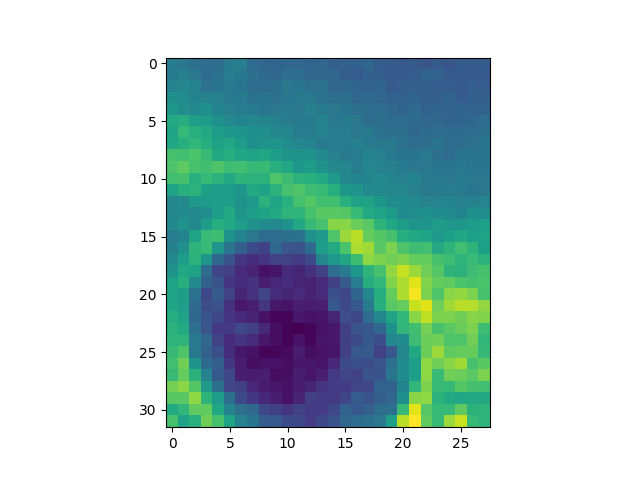

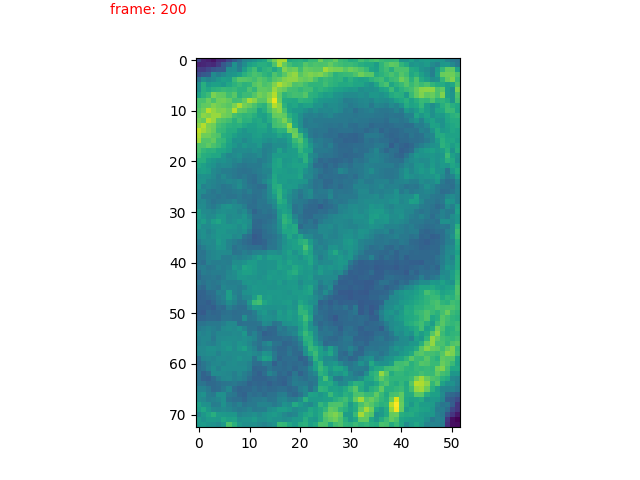

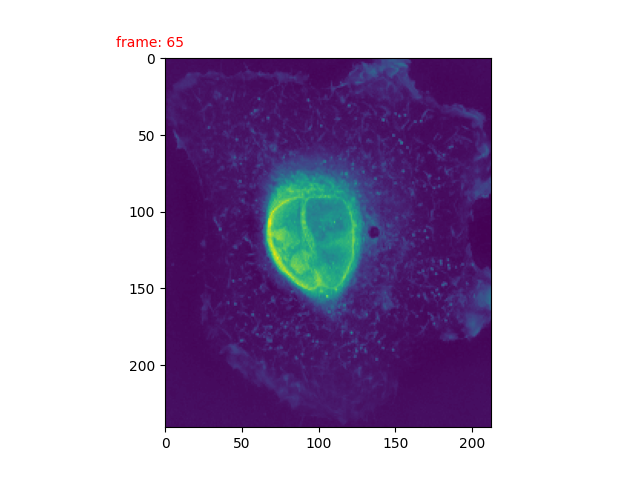

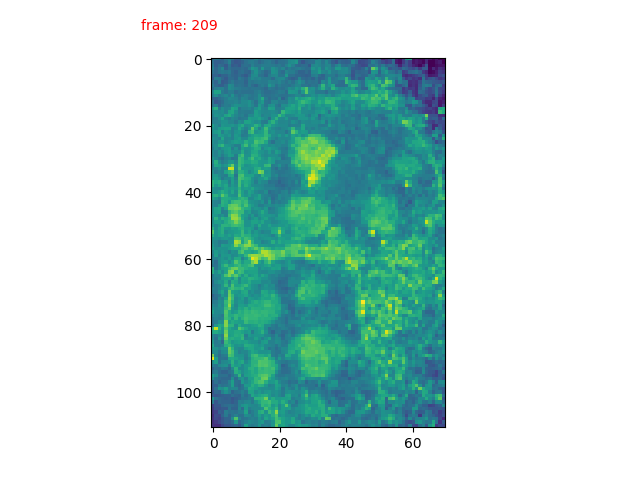

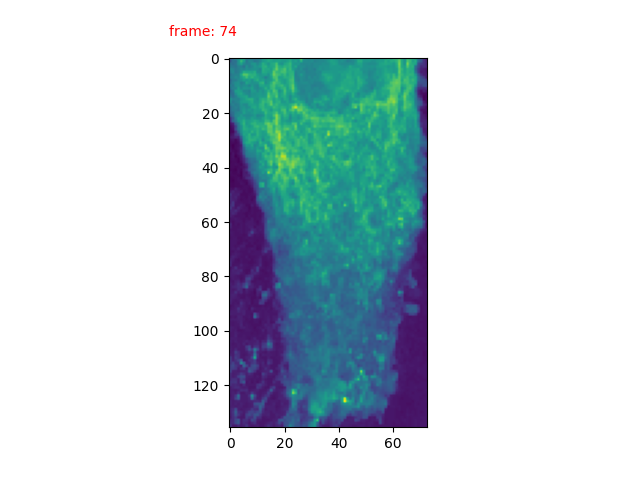

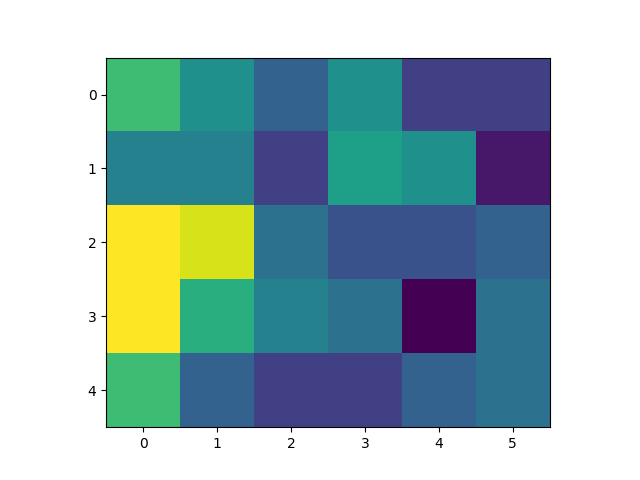

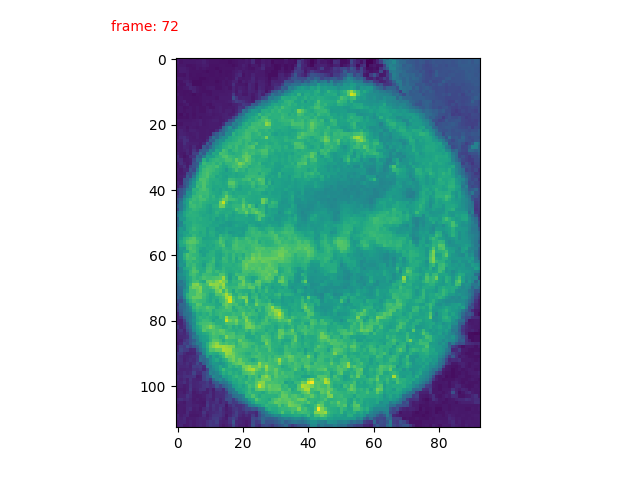

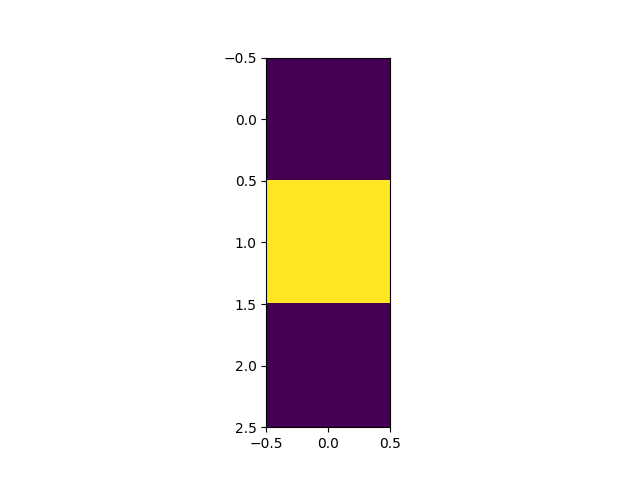

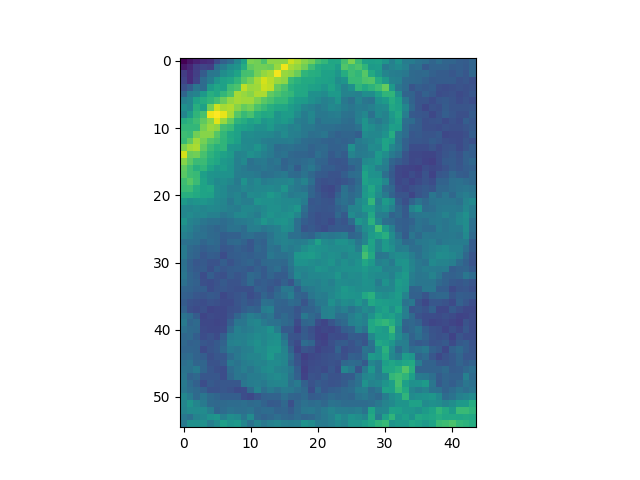

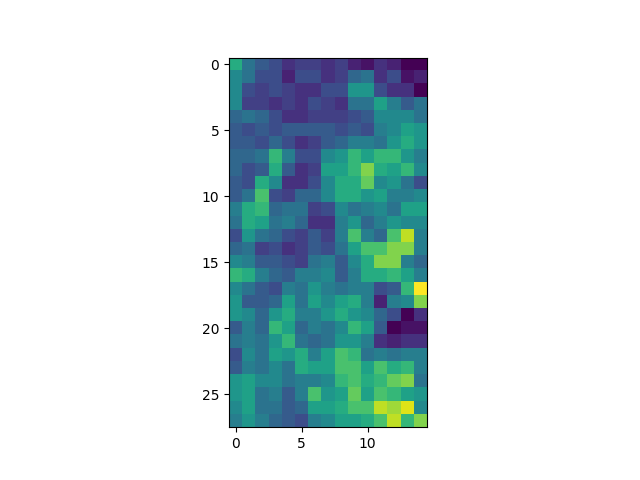

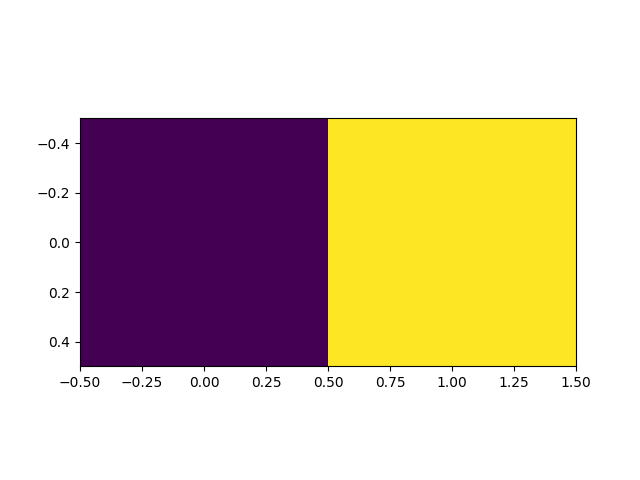

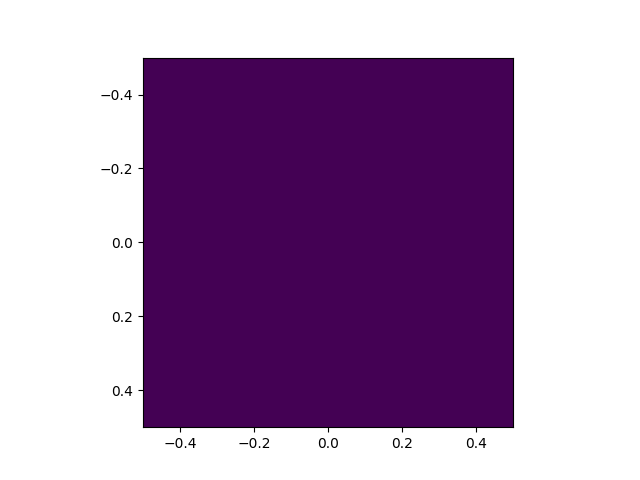

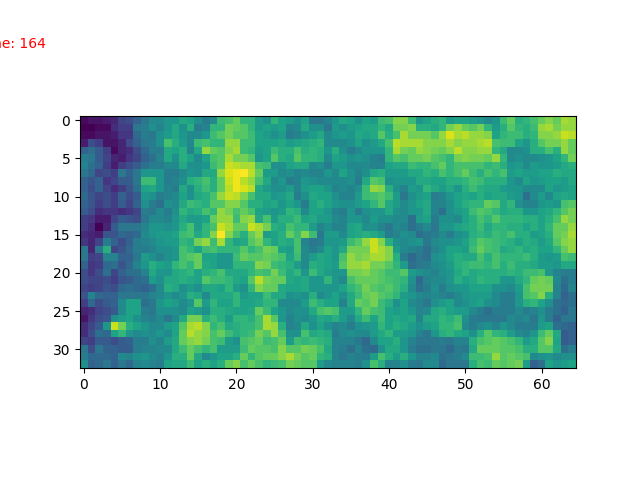

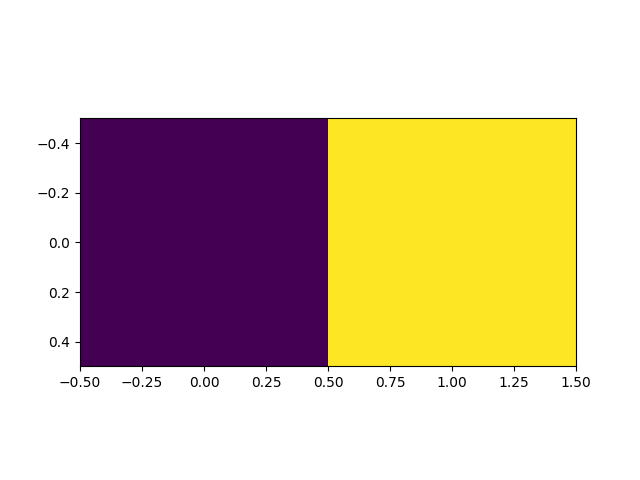

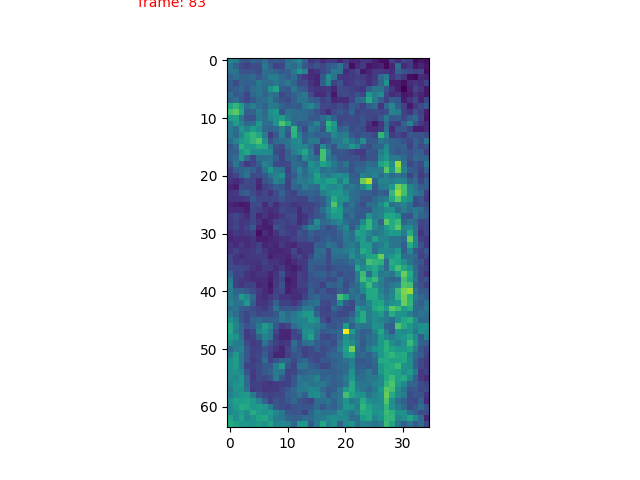

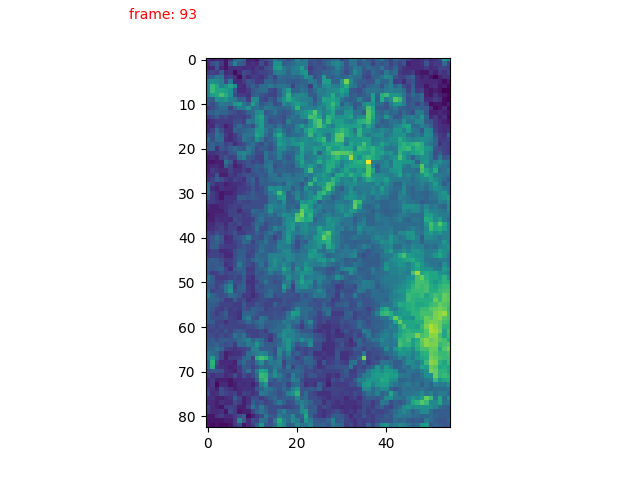

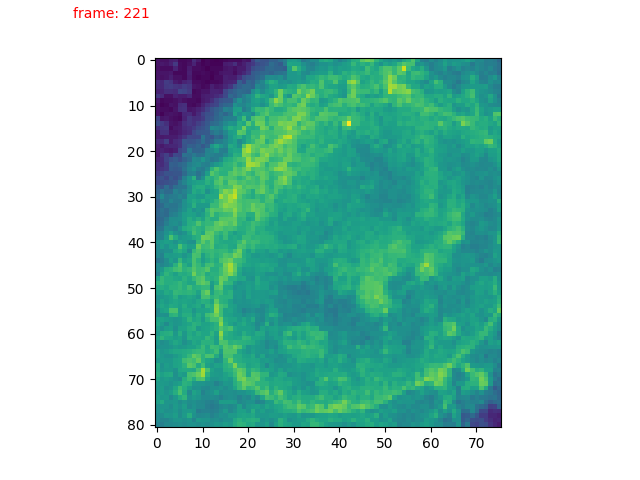

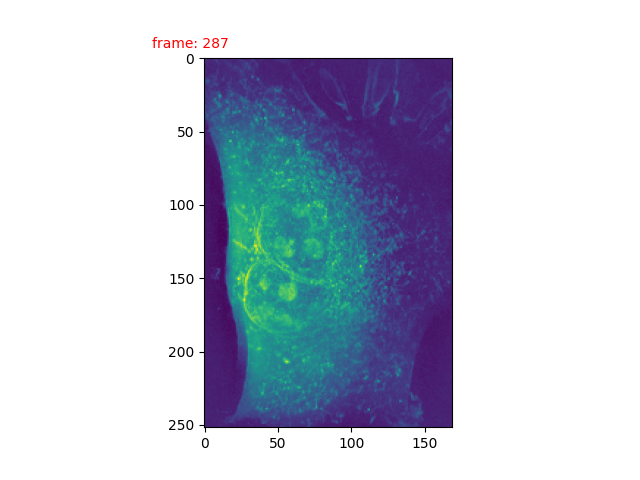

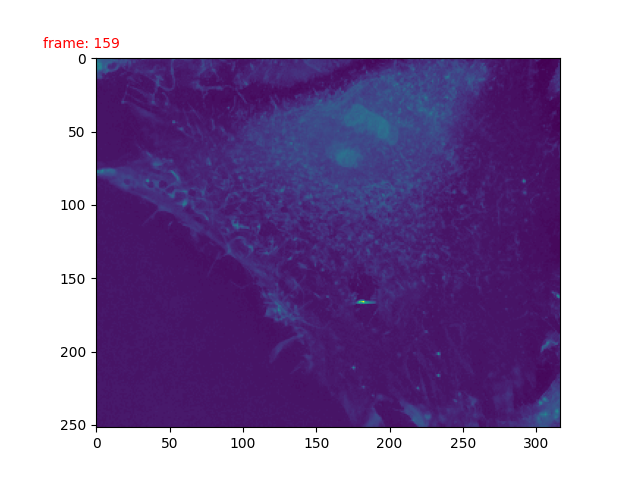

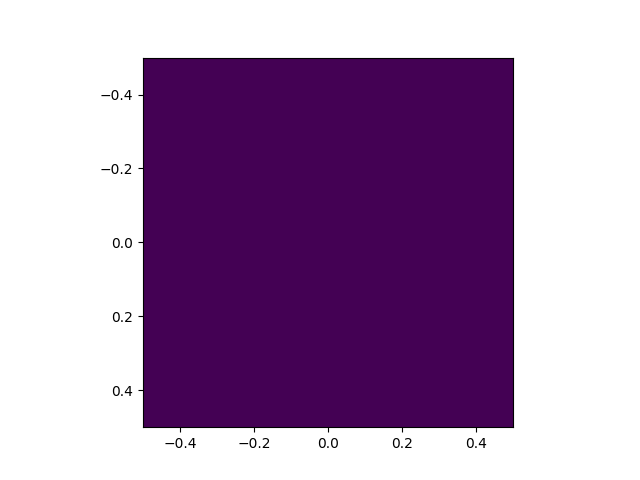

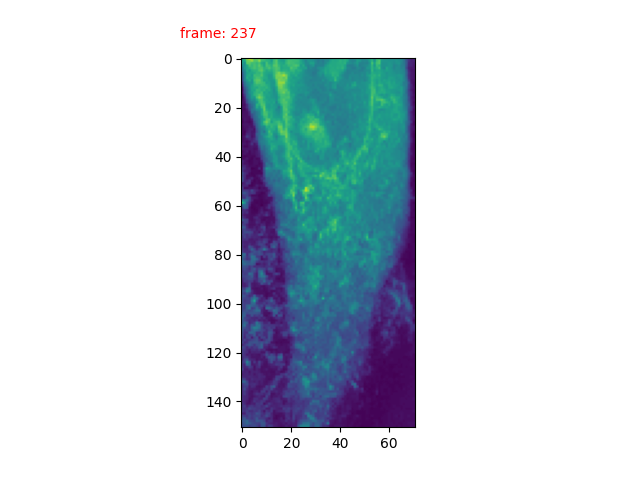

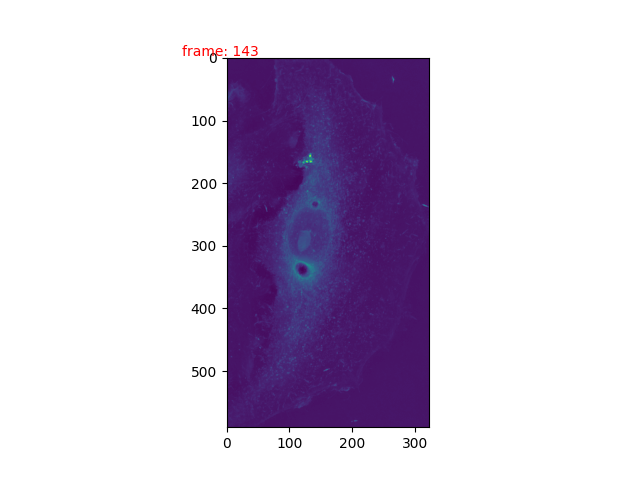

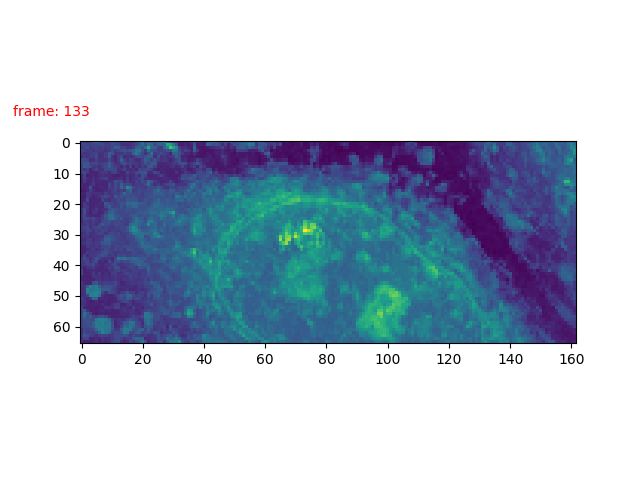

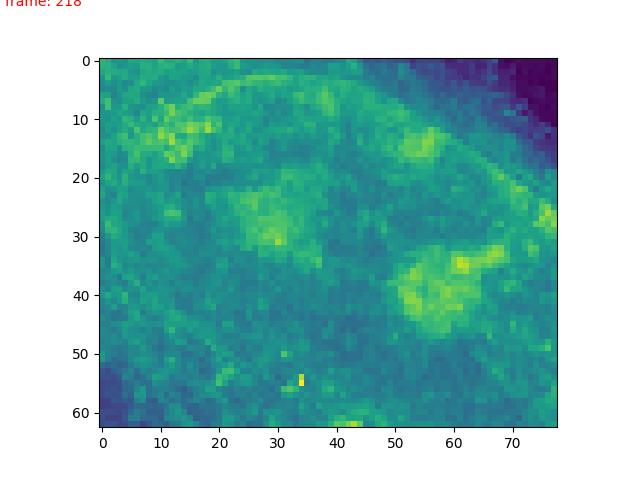

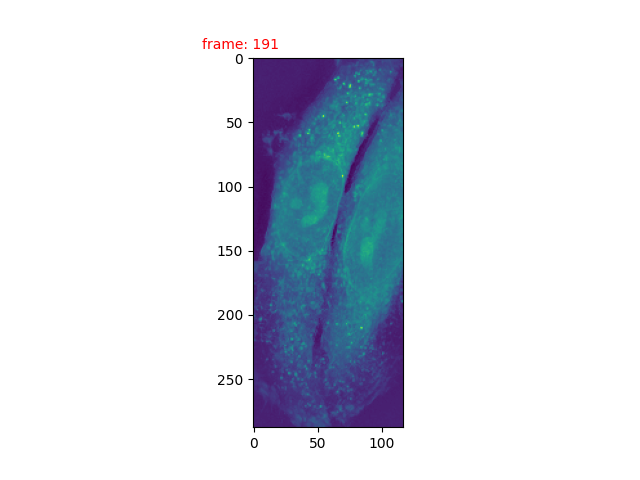

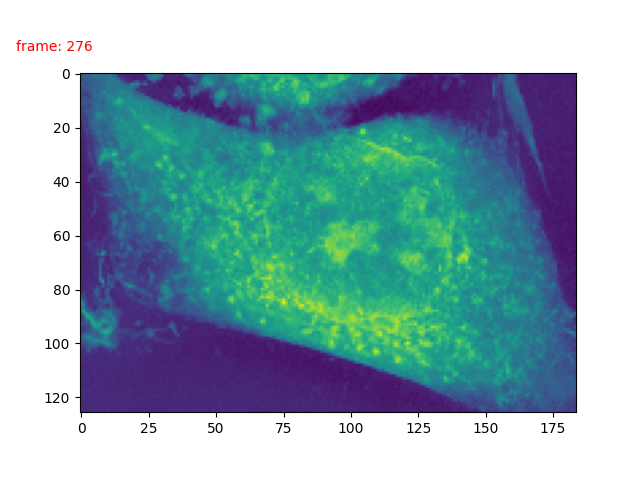

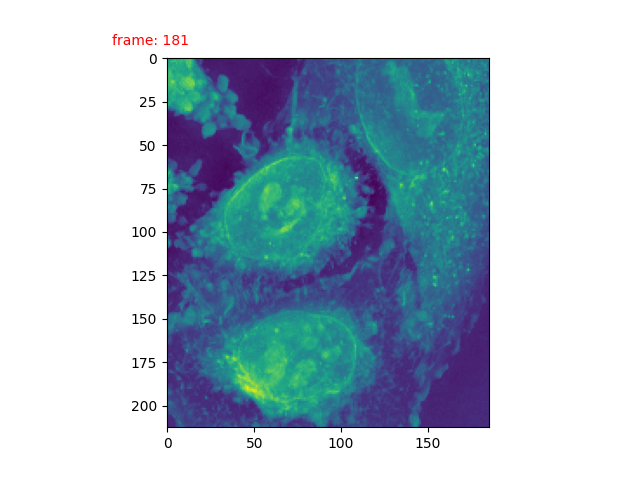

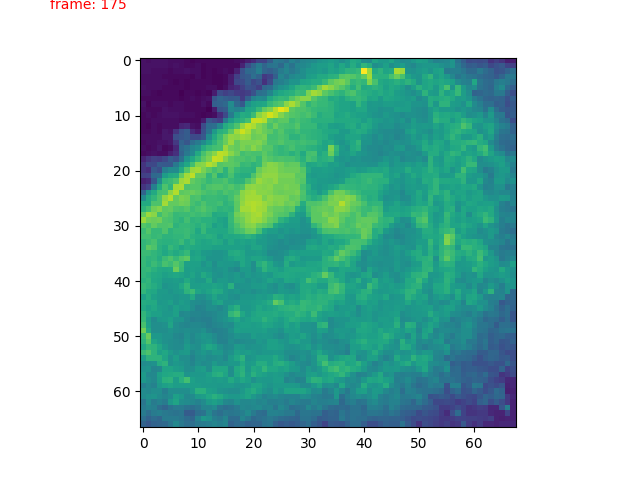

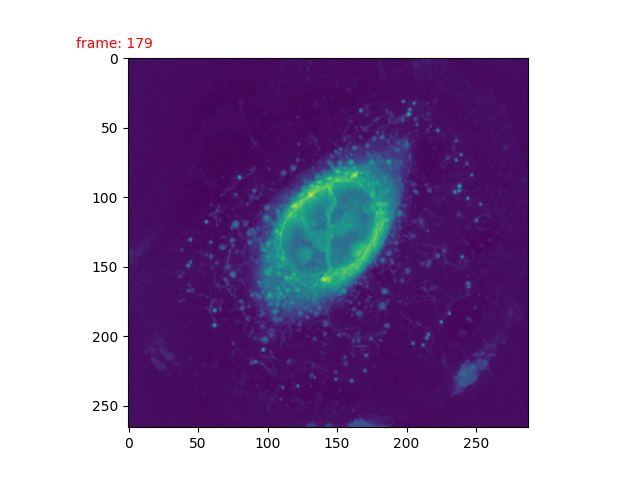

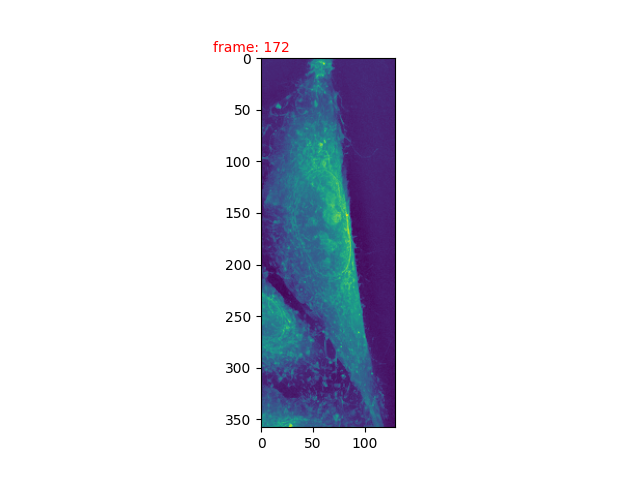

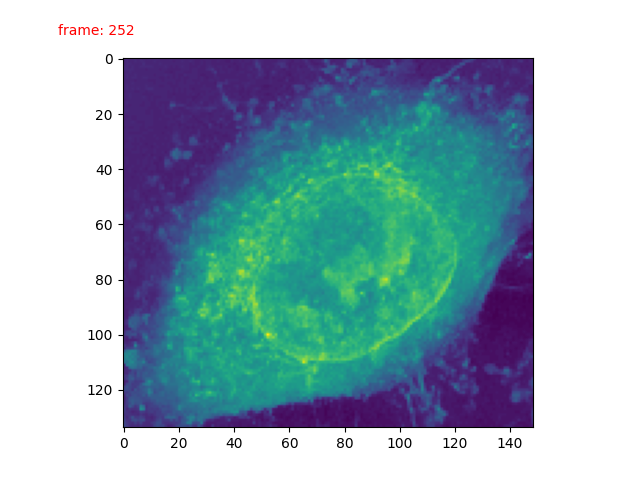

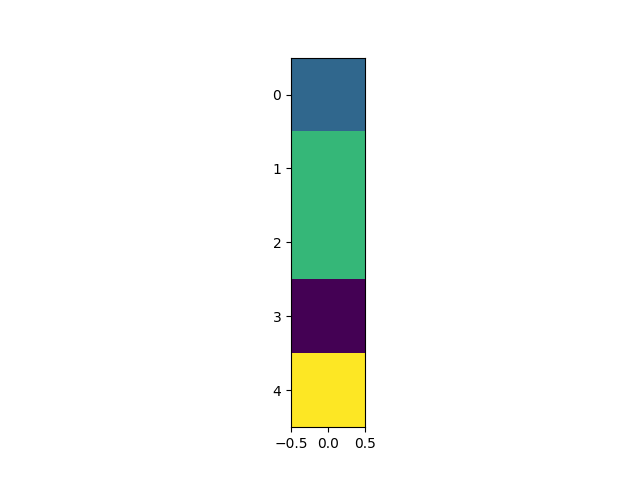

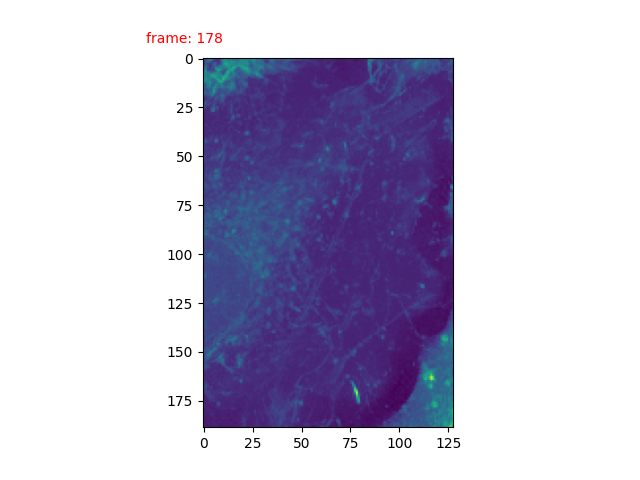

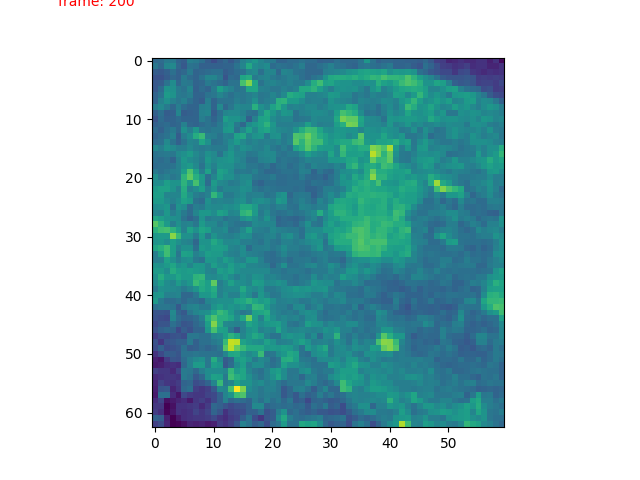

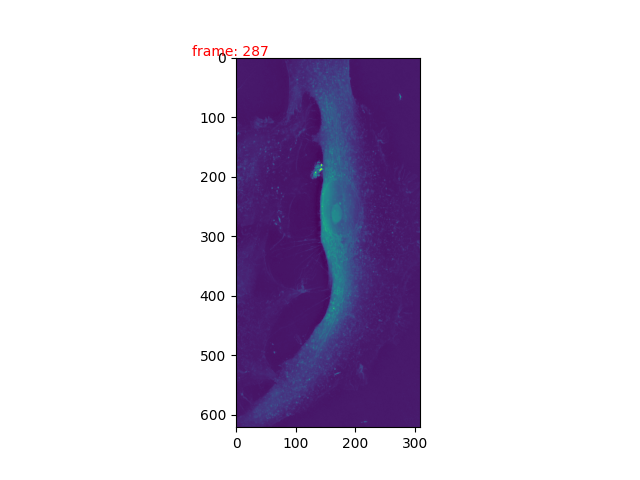

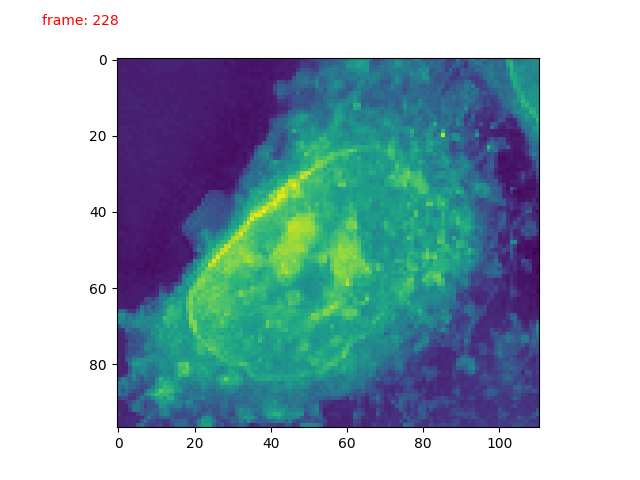

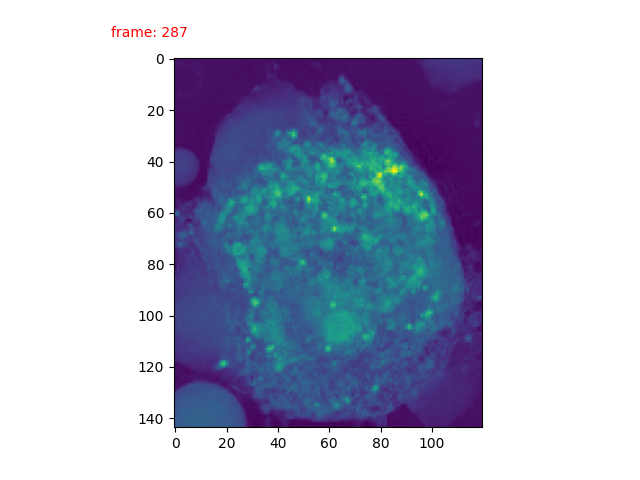

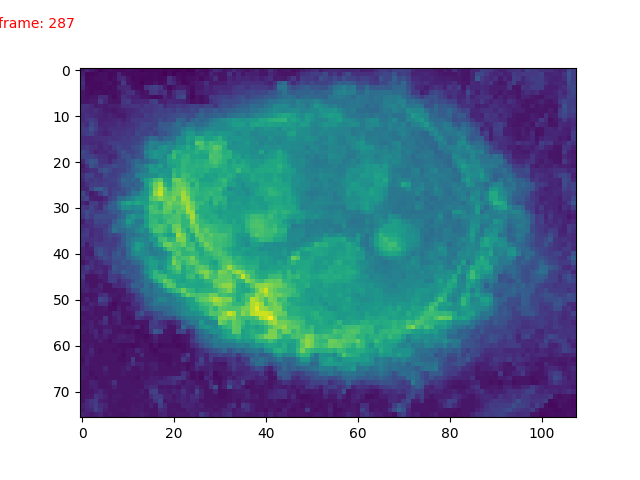

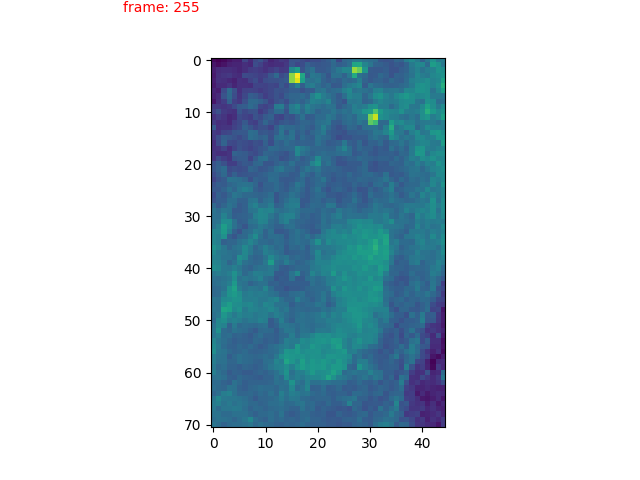

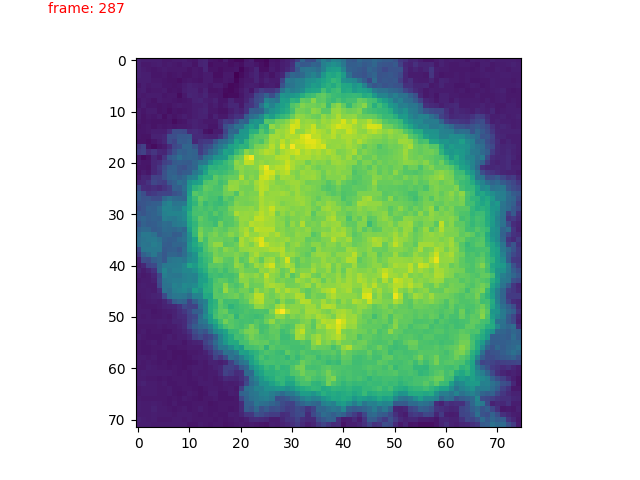

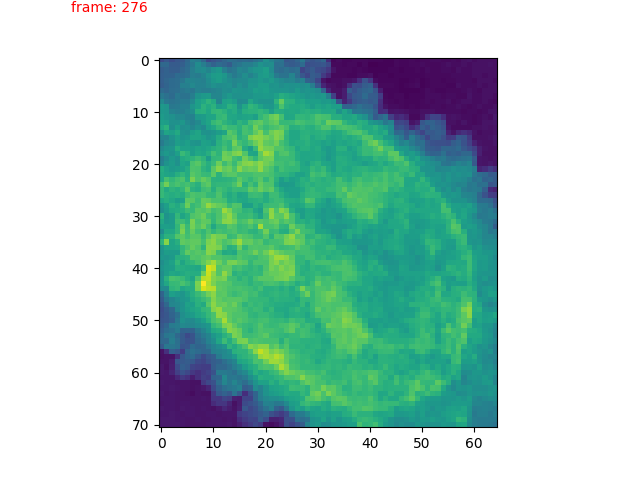

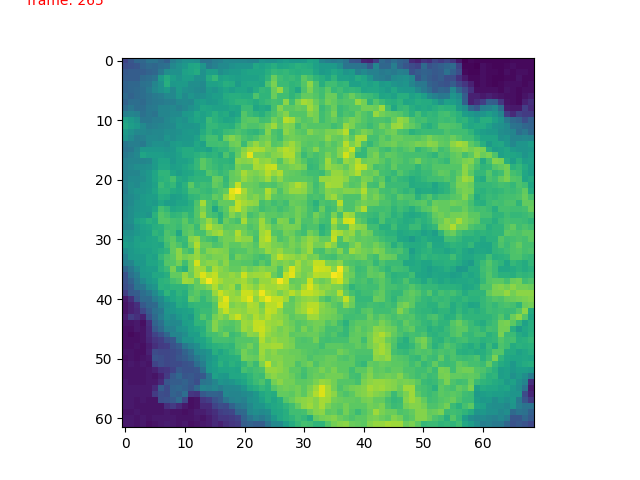

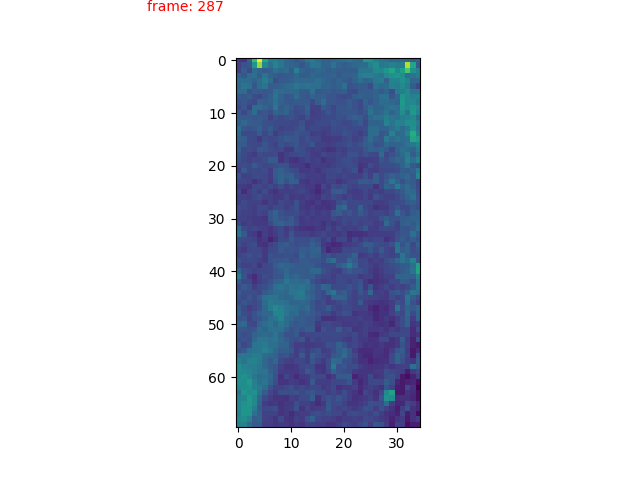

In [14]:
# for interactive display in visual studio code or jupyter notebook
%matplotlib ipympl

%mkdir raw_yuzhong_cellprofiler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

def visualize_traj(traj_row_indices, imgs, cell_track_db_df, save_path="./test.gif"):
    """visualize trajectory by matlpotlib animation and save to a gif file

    Parameters
    ----------
    traj_row_indices : _type_
        a list of row indices in cell_track_db_df
    imgs : _type_
        _description_
    cell_track_db_df : _type_
        _description_
    save_path : str, optional
        _description_, by default "./test.gif"

    Returns
    -------
    _type_
        _description_
    """    
    print("----> visualizing trajectory...")
    non_zero_traj_count = count_traj_existing_indices(traj_row_indices)
    print("#trajectory nonzero frames:", non_zero_traj_count)

    fig, ax = plt.subplots()
    def init():
        return []

    def update(frame):
        frame_idx, frame_img = frame
        ax.cla()
        frame_text = ax.text(-10, -10, "frame: {}".format(frame_idx), fontsize=10, color="red", ha="center", va="center")
        ax.imshow(frame_img)
        
        
        return []

    frame_data = []
    counter = 1
    for frame_idx, row_idx in enumerate(traj_row_indices):
        # the cell maybe missing in the current frame
        if row_idx == TRAJ_MISSING_INDEX:
            continue

        max_x = cell_track_db_df[MAX_X_COL][row_idx]
        max_y = cell_track_db_df[MAX_Y_COL][row_idx]
        min_x = cell_track_db_df[MIN_X_COL][row_idx]
        min_y = cell_track_db_df[MIN_Y_COL][row_idx]
        
        min_x, max_x, min_y, max_y = int(min_x), int(max_x), int(min_y), int(max_y)

        # Note the index difference here: 1-base for CellProfiler and 0-base for list index
        img_idx = cell_track_db_df[IMG_NUM_COL][row_idx] - 1
        img = imgs[img_idx]

        img_crop = img[min_y:max_y, min_x:max_x]
        frame_data.append((frame_idx, img_crop))

        # # debug prints
        # print("row_index:", row_idx, "frame_idx:", frame_idx, "img_idx:", img_idx)
        # print((min_x, max_x, min_y, max_y))


    ani = FuncAnimation(fig, update, frames=frame_data,
                    init_func=None, blit=True)

    print("saving to: %s..." % save_path)
    ani.save(save_path)

output_dir = Path("./raw_yuzhong_cellprofiler/")
for i in range(traj_row_idx_df.shape[0]):
    temp_traj = traj_row_idx_df.iloc[i, :]
    if count_traj_existing_indices(temp_traj) < 40:
        print("skipping traj:", i)
        continue
    save_path = output_dir/f"traj_{i}.gif"
    visualize_traj(temp_traj, imgs, cell_track_db_df, save_path=save_path)
    # plt.show()